# 1. Import Libraries & Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn import metrics, preprocessing, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
# sns.set(style="white")
# sns.set(style="whitegrid", color_codes=True)
import warnings
import plotnine as p9
from plotnine import *
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import make_pipeline
from pylab import rcParams

%matplotlib inline 

In [3]:
df_origin = pd.read_csv('sephora_merge_fnum_filter_short1.csv',encoding = 'unicode_escape')
df_origin.columns

Index(['brand_name', 'product_name', 'product_url', 'price', 'total_loves',
       'total_reviews', 'overall_rating', 'product_ingredients', 'normal_skin',
       'oily_skin', 'combo_skin', 'dry_skin', 'sensitive_skin',
       'chemical_present', 'skin_tone', 'recommended'],
      dtype='object')

In [4]:
df_origin.shape


(8408, 16)

In [5]:
df_origin1 = df_origin[df_origin.chemical_present == 0]
# df_origin1.shape

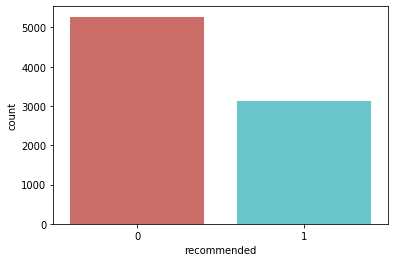

<Figure size 432x288 with 0 Axes>

In [6]:
sns.countplot(x='recommended', data = df_origin, palette = 'hls')
plt.show()
plt.savefig('count_plot')

In [7]:

print(df_origin['recommended'].value_counts()[1])
print(df_origin['recommended'].value_counts()[0])

3135
5273


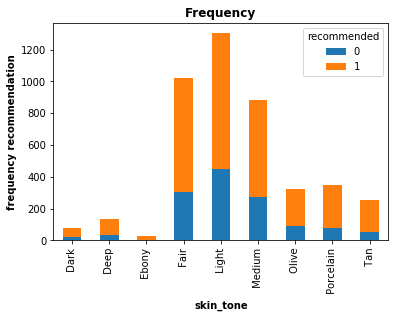

<Figure size 432x288 with 0 Axes>

In [8]:
pd.crosstab(df_origin['skin_tone'], df_origin['recommended']).plot(kind='bar', stacked=True)
plt.title('Frequency', fontweight='bold')
plt.xlabel('skin_tone',fontweight='bold')
plt.ylabel('frequency recommendation',fontweight='bold')
plt.show()
plt.savefig('recommend frequency')


In [9]:
len(df_origin['product_name'].unique())

# df['recommended'].value_counts()

298

## 1.1 Get a Subset of Data for Analysis

In [43]:
# removed 'normal_skin','combo_skin': highly correlated with otehr variables
df = df_origin[['price','total_reviews', 'overall_rating',
       'oily_skin', 'dry_skin', 'sensitive_skin', 
                'skin_tone', 'recommended']]

df.head()

,price,total_reviews,overall_rating,oily_skin,dry_skin,sensitive_skin,skin_tone,recommended
0,68,2847,4.1,1,1,0,Medium,1
1,68,2847,4.1,1,1,0,Light,1
2,68,2847,4.1,1,1,0,Light,1
3,68,2847,4.1,1,1,0,Light,1
4,68,2847,4.1,1,1,0,Medium,1


In [44]:
df['recommended'].value_counts()

0    5273
1    3135
Name: recommended, dtype: int64

## 1.2 Preparing Data

In [45]:
# Code dummy variables in the data 

df = pd.get_dummies(df, columns=['skin_tone'],
                    prefix=['skin_tone'],drop_first = True)
df.head(2)

,price,total_reviews,overall_rating,oily_skin,dry_skin,sensitive_skin,recommended,skin_tone_ Deep,skin_tone_ Ebony,skin_tone_ Fair,skin_tone_ Light,skin_tone_ Medium,skin_tone_ Olive,skin_tone_ Porcelain,skin_tone_ Tan
0,68,2847,4.1,1,1,0,1,0,0,0,0,1,0,0,0
1,68,2847,4.1,1,1,0,1,0,0,0,1,0,0,0,0


In [46]:
df.shape

(8408, 15)

# 1.3 Inspect correlation - check whether there are strong corerlations between input features

,price,total_reviews,overall_rating,oily_skin,dry_skin,sensitive_skin,recommended,skin_tone_ Deep,skin_tone_ Ebony,skin_tone_ Fair,skin_tone_ Light,skin_tone_ Medium,skin_tone_ Olive,skin_tone_ Porcelain,skin_tone_ Tan
price,1.00,-0.14,0.07,-0.14,-0.20,0.02,-0.15,-0.04,-0.02,-0.06,-0.05,-0.03,-0.03,-0.05,-0.03
total_reviews,-0.14,1.00,0.15,0.09,0.16,0.03,-0.12,0.00,-0.00,-0.05,-0.03,-0.04,-0.03,-0.03,-0.03
overall_rating,0.07,0.15,1.00,-0.11,0.02,-0.07,0.18,0.01,0.01,0.01,0.03,0.04,0.02,0.03,0.03
oily_skin,-0.14,0.09,-0.11,1.00,0.43,0.23,0.16,0.04,-0.01,0.05,0.07,0.04,0.03,0.04,0.05
dry_skin,-0.20,0.16,0.02,0.43,1.00,0.38,0.25,0.04,0.02,0.08,0.09,0.08,0.04,0.07,0.06
sensitive_skin,0.02,0.03,-0.07,0.23,0.38,1.00,-0.05,-0.01,0.01,-0.04,-0.04,-0.01,-0.01,-0.00,-0.01
recommended,-0.15,-0.12,0.18,0.16,0.25,-0.05,1.00,0.10,0.06,0.25,0.25,0.23,0.14,0.18,0.16
skin_tone_ Deep,-0.04,0.00,0.01,0.04,0.04,-0.01,0.10,1.00,-0.01,-0.05,-0.05,-0.04,-0.03,-0.03,-0.02
skin_tone_ Ebony,-0.02,-0.00,0.01,-0.01,0.02,0.01,0.06,-0.01,1.00,-0.02,-0.03,-0.02,-0.01,-0.01,-0.01
skin_tone_ Fair,-0.06,-0.05,0.01,0.05,0.08,-0.04,0.25,-0.05,-0.02,1.00,-0.16,-0.13,-0.07,-0.08,-0.07


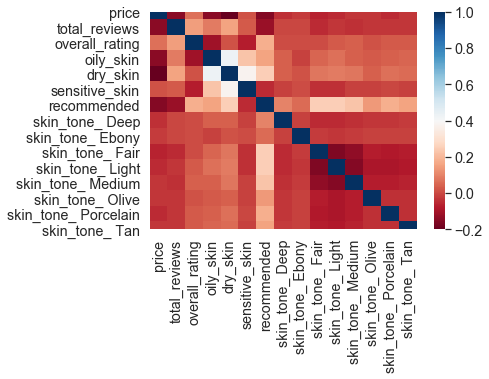

In [47]:
## see correlation results

corr = df.corr().round(2)
display(corr)

sns.set(font_scale=1.3)
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = 'RdBu')

# 2. Machine Learning Model - Logistic Regression 

# Stepwise Logistic Regression 

In [48]:
# split the data
X = df.loc[:, df.columns != 'recommended']
y = df.loc[:, df.columns == 'recommended']

# normalize data
scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns = X.columns).round(2)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=0)

## 2.1 Feature Elimination 

In [49]:
# fit the model - backward elimination 
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(method='bfgs')
print(result.summary())

         Current function value: 0.408058
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:            recommended   No. Observations:                 6726
Model:                          Logit   Df Residuals:                     6712
Method:                           MLE   Df Model:                           13
Date:                Sun, 20 Oct 2019   Pseudo R-squ.:                  0.3813
Time:                        19:11:25   Log-Likelihood:                -2744.6
converged:                      False   LL-Null:                       -4436.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
price                   -0.2029      0.042     -4.886   

/anaconda3/envs/insight/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [50]:
# check feature importance 
coefs = np.exp(result.params) # turn the estimated coefficients in log-odds format into regular odds.
coefs

price                   0.816363
total_reviews           0.715708
overall_rating          1.669793
oily_skin               1.172612
dry_skin                1.422445
sensitive_skin          0.860840
skin_tone_ Deep         1.610236
skin_tone_ Ebony        1.495121
skin_tone_ Fair         2.735221
skin_tone_ Light        2.743289
skin_tone_ Medium       2.640563
skin_tone_ Olive        1.876014
skin_tone_ Porcelain    2.149642
skin_tone_ Tan          1.965777
dtype: float64

In [51]:
df_coefs = pd.DataFrame({ 'coefs': coefs, 'features': X.columns,})
print(df_coefs)

                         coefs              features
price                 0.816363                 price
total_reviews         0.715708         total_reviews
overall_rating        1.669793        overall_rating
oily_skin             1.172612             oily_skin
dry_skin              1.422445              dry_skin
sensitive_skin        0.860840        sensitive_skin
skin_tone_ Deep       1.610236       skin_tone_ Deep
skin_tone_ Ebony      1.495121      skin_tone_ Ebony
skin_tone_ Fair       2.735221       skin_tone_ Fair
skin_tone_ Light      2.743289      skin_tone_ Light
skin_tone_ Medium     2.640563     skin_tone_ Medium
skin_tone_ Olive      1.876014      skin_tone_ Olive
skin_tone_ Porcelain  2.149642  skin_tone_ Porcelain
skin_tone_ Tan        1.965777        skin_tone_ Tan


In [52]:
df_coefs_sort = df_coefs.sort_values('coefs', ascending=False)
df_coefs_sort

,coefs,features
skin_tone_ Light,2.743289,skin_tone_ Light
skin_tone_ Fair,2.735221,skin_tone_ Fair
skin_tone_ Medium,2.640563,skin_tone_ Medium
skin_tone_ Porcelain,2.149642,skin_tone_ Porcelain
skin_tone_ Tan,1.965777,skin_tone_ Tan
skin_tone_ Olive,1.876014,skin_tone_ Olive
overall_rating,1.669793,overall_rating
skin_tone_ Deep,1.610236,skin_tone_ Deep
skin_tone_ Ebony,1.495121,skin_tone_ Ebony
dry_skin,1.422445,dry_skin


In [53]:
objects = df_coefs_sort.index

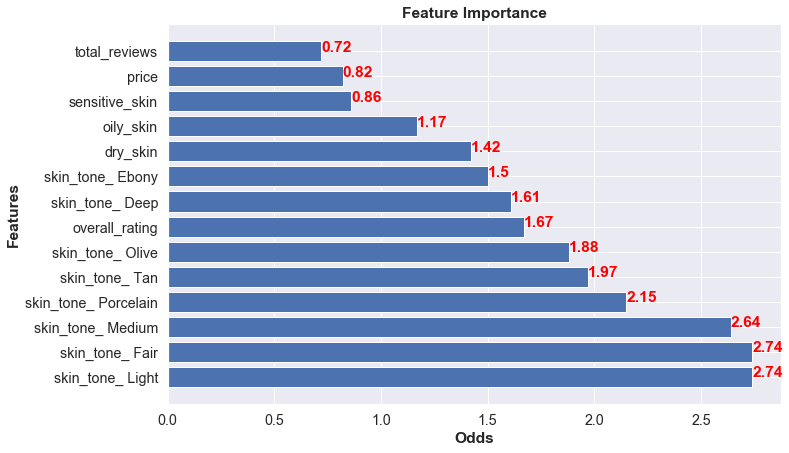

In [54]:
y_pos = np.arange(len(objects))
performance = df_coefs_sort['coefs'].values.round(2)
# performance = df_coefs.sort_values('coefs', ascending=False).round(2)
plt.figure(figsize=(11,7))
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Odds', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.title('Feature Importance', fontweight='bold')

for i, v in enumerate(performance):
    plt.text(v, i, str(v), color='red', fontweight='bold')
    
plt.show()

In [55]:
df.columns

Index(['price', 'total_reviews', 'overall_rating', 'oily_skin', 'dry_skin',
       'sensitive_skin', 'recommended', 'skin_tone_ Deep', 'skin_tone_ Ebony',
       'skin_tone_ Fair', 'skin_tone_ Light', 'skin_tone_ Medium',
       'skin_tone_ Olive', 'skin_tone_ Porcelain', 'skin_tone_ Tan'],
      dtype='object')

## 2.2 Implement the Model
- fit the Logistic Regression Model with selected features

In [56]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('-'*60)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(logreg.score(X_train, y_train)))
print('-'*60)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))
print('-'*60)

print(classification_report(y_test, y_pred))
print('-'*60)

------------------------------------------------------------
Accuracy of logistic regression classifier on train set: 0.8537
------------------------------------------------------------
Accuracy of logistic regression classifier on test set: 0.8395
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1043
           1       0.73      0.93      0.81       639

    accuracy                           0.84      1682
   macro avg       0.84      0.86      0.84      1682
weighted avg       0.86      0.84      0.84      1682

------------------------------------------------------------


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
# check the coeffcients
print(logreg.coef_)
print(logreg.intercept_)

[[-0.27538407 -0.4081964   0.54413681  0.18142873  0.49570766 -0.11265862
   0.57230361  0.29426988  1.35001294  1.4090359   1.27674913  0.81261992
   0.88392489  0.76851984]]
[-1.33649385]


In [58]:
# print results

cm = confusion_matrix(y_test, y_pred)
cm_sum = np.sum(cm, axis =1, keepdims = True)
cm_perc = cm/cm_sum.astype(float)
array = cm_perc
cm_df = pd.DataFrame(array, index = [i for i in ['Recommend','Not_Recommend']], 
                             columns = [i for i in ['Recommend','Not_Recommend']])


In [59]:
print(cm_df.round(2))

               Recommend  Not_Recommend
Recommend           0.79           0.21
Not_Recommend       0.07           0.93


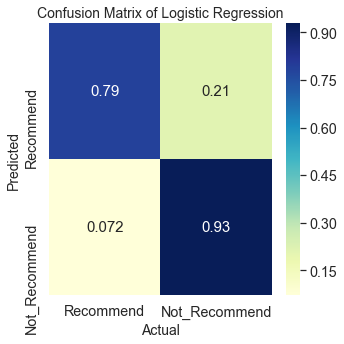

In [60]:
# visualize the model

plt.figure(figsize=(5,5))
plt.title('Confusion Matrix of Logistic Regression', fontsize = 14)
sns.heatmap(cm_df, annot = True, annot_kws={'size': 15}, cmap="YlGnBu")
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted',fontsize = 14)
plt.ylim(2,0);

# prone to false positive 

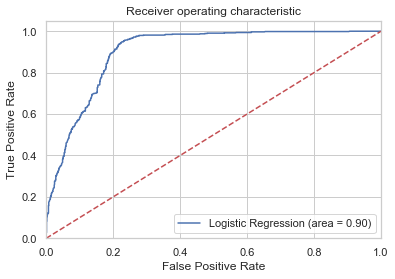

--------------------------------------------------
The area under the curve is: 0.903
--------------------------------------------------


In [61]:
# ROC Curve:
plt.rc("font", size=20)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print('-'*50)
print("The area under the curve is:", roc_auc_score(y_test,logreg.predict_proba(X_test)[:,1]).round(3))
print('-'*50)

## 2.1.4 Adjust the classification threshhold

In [62]:
# check the first 10 predicted responses 

y_predict = logreg.predict(X_test)
y_predict[0:10]

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [63]:
y_predict_prob = logreg.predict_proba(X_test)[:,1]
y_predict_prob[0:10]

array([0.71142455, 0.79461524, 0.75174974, 0.02455112, 0.03599737,
       0.80052146, 0.05262697, 0.84970259, 0.02533039, 0.79461524])

Text(0, 0.5, 'Frequency')

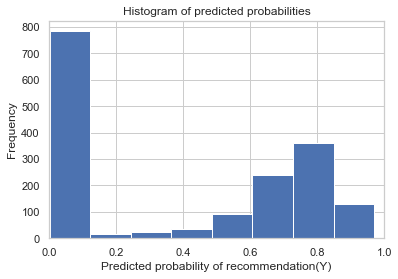

In [64]:
plt.hist(y_predict_prob, bins=8)
# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of recommendation(Y)')
plt.ylabel('Frequency')

# need to increase the the shrehold

In [65]:
THRESHOLD = 0.7
y_pred_class = np.where(y_predict_prob > THRESHOLD, 1, 0)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[909 134]
 [215 424]]


In [66]:
cm = confusion_matrix(y_test, y_pred_class)
cm_sum = np.sum(cm, axis =1, keepdims = True)
cm_perc = cm/cm_sum.astype(float)
array = cm_perc
cm_df = pd.DataFrame(array, index = [i for i in ['Recommend','Not_Recommend']], 
                             columns = [i for i in ['Recommend','Not_Recommend']])

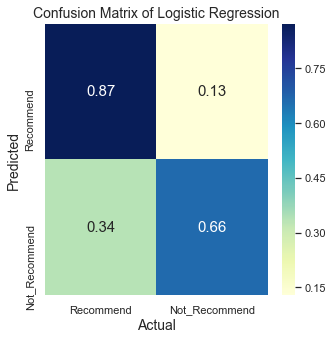

In [67]:
plt.figure(figsize=(5,5))
plt.title('Confusion Matrix of Logistic Regression', fontsize = 14)
sns.heatmap(cm_df, annot = True, annot_kws={'size': 15}, cmap="YlGnBu")
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted',fontsize = 14)
plt.ylim(2,0);

In [68]:
pd.DataFrame(data=[accuracy_score(y_test, y_pred_class), recall_score(y_test, y_pred_class),
                   precision_score(y_test, y_pred_class), roc_auc_score(y_test, y_pred_class)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.792509
recall,0.663537
precision,0.759857
roc_auc_score,0.767531
